# PyTorch DataSets and DataLoaders
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/9.data-loaders.ipynb)

By [Terence Parr](https://explained.ai).

PyTorch has support to manage data sets and deal with all of the minibatching that we managed manually in the previous notebook. They can do a lot more, but we will focus just on the batching part here. Basically, we will pass in `TensorDataset(X_train, y_train)` and `TensorDataset(X_test, y_test)` instead of `X_train, y_train, X_test, y_test` to our training loop. Then, our loop can iterate through batches using `(batch_X, batch_y) in train_loader`.

## Support code

In [12]:
import os
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [13]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

As before, let's load a sample of 10,000 MNIST images:

In [14]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [15]:
X.shape

(10000, 784)

In [16]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

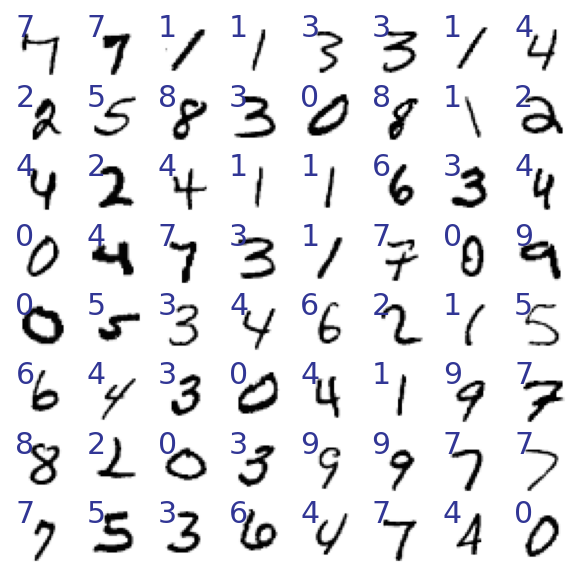

In [17]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

As before, create tensors from the $\bf X$ and $\bf y$ data, move the data to the GPU, and split out a validation set:

In [18]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop using TensorDataset and DataLoader

The data loaders simplify our training loop, though of course we still need to loop over the batches.  Take a look at the difference between the manual versus data loader mini-batching.

<img src="images/dataloader.png" width="800">

In [19]:
def sgdtrain(model:nn.Module,
             train_data:TensorDataset,  # contains X_train, y_train
             valid_data:TensorDataset,  # contains X_test, y_test
             learning_rate = .0001, nepochs=2000, batch_size=32):
    train_loader = DataLoader(train_data, batch_size=batch_size)
    X_train, y_train = train_data.tensors
    X_test, y_test = train_data.tensors
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        for bi, (batch_X, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # This construct is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        # in this block of code
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

Rather than pass in

```python
X_train, y_train, X_test, y_test
```

to the training loop function, we pass combined data sets:

```python
 TensorDataset(X_train, y_train), # combine X,y
 TensorDataset(X_test, y_test),   # combine X,y
```

In [26]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)
model = model.to(device) # make sure the model runs on the GPU as well

history,_ = sgdtrain(model,
                     TensorDataset(X_train, y_train), # combine X,y
                     TensorDataset(X_test, y_test),   # combine X,y
                     learning_rate = .001, nepochs=100,
                     batch_size=64
                  )

Epoch    0 cross entropy loss  1.7450   test loss  1.6916
Epoch   10 cross entropy loss  1.5365   test loss  1.5108
Epoch   20 cross entropy loss  1.5236   test loss  1.4932
Epoch   30 cross entropy loss  1.5224   test loss  1.4868
Epoch   40 cross entropy loss  1.5218   test loss  1.4846
Epoch   50 cross entropy loss  1.5064   test loss  1.4831
Epoch   60 cross entropy loss  1.4770   test loss  1.4819
Epoch   70 cross entropy loss  1.4616   test loss  1.4799
Epoch   80 cross entropy loss  1.4614   test loss  1.4784
Epoch   90 cross entropy loss  1.4649   test loss  1.4847
Epoch  100 cross entropy loss  1.4613   test loss  1.4775
BEST test cross entropy loss 1.478 at epoch 98


In [27]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.983


In [28]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.961


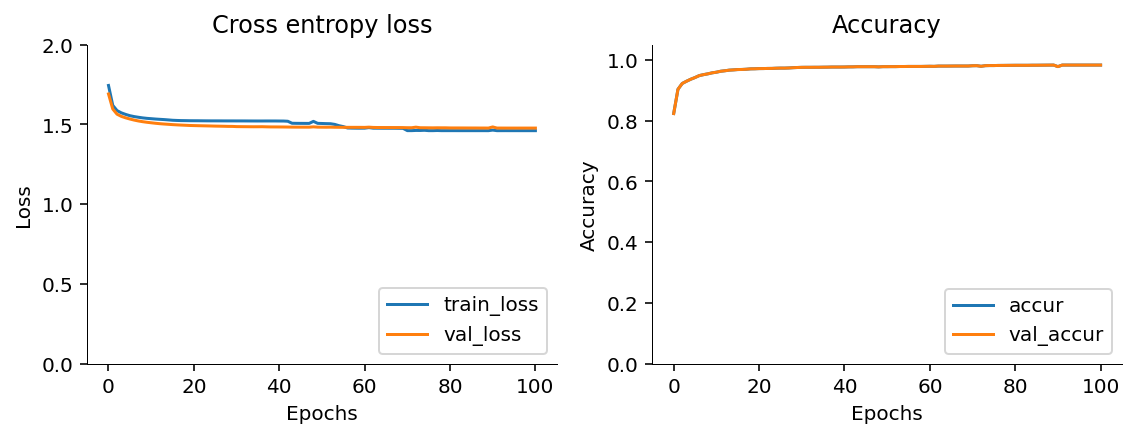

In [30]:
fig, axes = plt.subplots(1,2, figsize=(8,3))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()